## Authentication 

After importing `ee`, the `ee.Authenticate()` line should be run once to grant the notebook access to Earth Engine using your account. This triggers the authentication flow, which is easy to complete. [Here](https://developers.google.com/earth-engine/guides/python_install#authentication), you can find a step-by-step instructions.


In [1]:
#%pip install earthengine-api --upgrade
#%pip install geemap

In [4]:
import ee
# # If you are running this notebook for the first time, you need to activate the command below for the authentication flow:
#ee.Authenticate()

## Initializing 

Run the following scripts to initialize the API. You should see this message "Google Earth Engine has initialized successfully!"

In [5]:
try:
    # Initialize the library.
    ee.Initialize()
    print('Google Earth Engine has initialized successfully!')
except ee.EEException as e:
    print('Google Earth Engine has failed to initialize!')
except:
    print("Unexpected error:", sys.exc_info()[0])
    raise

Google Earth Engine has initialized successfully!


## Getting Data and Visualizing

In the GEE, datasets can be of different types:

- `ee.Feature`: a geometric object with a list of properties (vector data)
- `ee.Image`: an image that may include several bands (raster data)
- `ee.FeatureCollection`: groups of features
- `ee.ImageCollection`: groups of images


Let's use the [geemap](https://geemap.org/) Python package for defining the study area and the visualization. geemap is a Python package for interactive mapping with GEE. For video tutorials and notebook examples for the geemap Python package, please visit the [examples page](https://github.com/giswqs/geemap/tree/master/examples). For complete documentation on geemap modules and methods, please visit the [API Reference](https://geemap.org/geemap/#geemap-tutorials).

In [14]:
import geemap
import pickle
import os

Now let's call the interactive map from geemap to select a region or a point of interest. Please note that the following line opens a default basemap which is a Google Map (additional basemaps can be added using the `Map.add_basemap()` function).

In [12]:
areas_of_interest = {}

In [13]:
Map1 = geemap.Map()
Map1

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

Now let's zoom in (using a mouse) to the region of Enschede. Using the bar at the left side of the map, select a rectangle on this map (i.e., covering Enschede  and surroundings). This region will appear as "Drawn Features" layer on this map. You can check it out using the tool icon on the top right corner of the map. Then, you can retrieve this region geometry using the following lines.

In [17]:
# File name where the dictionary is stored
pickle_file = 'areas_of_interest.pickle'

# Initialize the areas_of_interest dictionary
if os.path.exists(pickle_file):
    # If the pickle file exists, load the dictionary from the file
    with open(pickle_file, 'rb') as handle:
        areas_of_interest = pickle.load(handle)
    print("Loaded areas of interest from pickle file.")
else:
    # If the pickle file does not exist, initialize an empty dictionary
    areas_of_interest = {}
    print("Initialized an empty dictionary for areas of interest.")

Loaded areas of interest from pickle file.


In [16]:
# Code for selecting the area
fc = ee.FeatureCollection(Map1.draw_last_feature)
region = fc.geometry()
coords = region.getInfo()['coordinates']
area_name = input("Enter a name for this area: ")

# Check if the area name already exists in the dictionary
if area_name in areas_of_interest:
    print(f"The area name '{area_name}' already exists. Please choose a different name.")
else:
    # Save the coordinates with area_name as ID
    areas_of_interest[area_name] = coords
    print(f"Area '{area_name}' saved successfully.")

    # Pickling the updated dictionary
    with open('areas_of_interest.pickle', 'wb') as handle:
        pickle.dump(areas_of_interest, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("Areas of interest have been pickled and saved.")

Area 'Enschede' saved successfully.
Areas of interest have been pickled and saved.


#### Print saved areas + coordinates

In [18]:
for name, coordinates in areas_of_interest.items():
    print(f"Area: {name}, Coordinates: {coordinates}")

Area: Enschede, Coordinates: [[[6.795044, 52.175827], [6.795044, 52.267317], [6.985588, 52.267317], [6.985588, 52.175827], [6.795044, 52.175827]]]


In [6]:
# fc = ee.FeatureCollection(Map1.draw_last_feature)
# region = fc.geometry()
# cords = region.getInfo()['coordinates']
# cords

In [7]:
# or alternatively use the following predefined rectangle
region = ee.Geometry.Polygon(
[[[6.815664, 52.17028],
  [6.815664, 52.25884],
  [6.969804, 52.25884],
  [6.969804, 52.17028],
  [6.815664, 52.17028]]]
)

Now it's the time to gather the Sentinel 2 images of this region. To know how to gather an specific data you can always check the [GEE data catalogue](https://developers.google.com/earth-engine/datasets). For example, according to the [Sentinel 2 satellite images catalogue ](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED), we can access these images using the "ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")" snippet.

Now let's find a recent [Sentinel 2 Multispectral satellite image](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED) that covers the selected region during the last summer. Let's consider all the images with less than 10% cloud coverage. We don't want very cloudy images!

In [8]:
myCollection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
    .filterBounds(region) \
    .filterDate('2022-06-01', '2022-08-30') \
    .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 10)

In [9]:
listOfImages = myCollection.aggregate_array('system:index').getInfo()
print('Number of images in the collection: ', len(listOfImages))

Number of images in the collection:  10


The first image and clip to the region and visualize it on the map.

Often, we don't need a whole image for furthur analysis. We can simply crop an image and select a smaller part of an image for the region of interest. You can use [Clip](https://developers.google.com/earth-engine/apidocs/ee-image-clip) to a Geometry or Feature for selecting part of an image. The output bands correspond exactly to the input bands, except data not covered by the geometry is masked. The output image retains the metadata of the input image.

In [10]:
img1 = myCollection.first().clip(region)

In [11]:
# Some visualization parameters: 
# - Values to map to 0 and values to map to 255. 
# - Three bands to be combined as an rgb image

# You can try changing these parameters and check the result!

vis_params = {"min": 0, 
              "max": 1500, 
              "bands": ["B4", "B3", "B2"]}  


In [12]:
Map2 = geemap.Map()
Map2.addLayer(img1, vis_params, "FirstImage", True) 
Map2

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

Scroll and zoom to find the image!

We can reduce an image collection by calculating the median of all values at each pixel across the stack of all matching bands.

In [13]:
img2 = myCollection.median().clip(region)
Map2.addLayer(img2, vis_params, "MedianImage", True) 
Map2

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

## Exporting the Data

For exporting data out of GEE we suggest to use the [geemap python package tools](https://geemap.org/notebooks/11_export_image/#download-an-eeimage).

In [14]:
# Let's first import some needed libraries

# %pip install rasterio
# %pip install numpy
# %pip install matplotlib

import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt

In [15]:
# let's create a Downloads folder and define a name for the data.

out_dir = os.path.join(os.path.expanduser('~'), 'Downloads')
filename = os.path.join(out_dir, 'Enschede.tif')

In [16]:
# Exporting all bands as one single image
# By "file_per_band=True" you can export each band as one image
# With the "scale" parameter you can change the spatial resolution of the exported image. 
# Higher spatial resolution (lower scale) leads to longer downloading time.

geemap.ee_export_image(
    img2, filename=filename, scale=27, region=region, file_per_band=False
)

Generating URL ...
Please wait ...
Data downloaded to C:\Users\windows-game-pc\Downloads\Enschede.tif



Now let's check if the data has been downloaded. Remember that we can open the image (raster data) using rasterio and visualize it.

You can also export an image to Google Drive using the following line of code. This could be useful for example for big images. Moreover, you can download an image collection using geemap tools. See [this tutorial](https://geemap.org/notebooks/11_export_image/#exporting-all-bands-as-one-single-image) for more details.

In [17]:
def read_tif_as_rgb(tif_path):
    """
    Read a tif file as a numpy array
    """
    with rasterio.open(tif_path) as src:
        raw_img =  src.read()
        img_t = np.transpose(raw_img[0:12,:,:], [1,2,0])
    return img_t[:,:,[3,2,1]] #select r,b,g chanels



def rgb_color_normalization(three_band_img,sigma):
    rows,columns,bands = three_band_img.shape
    #place holder np array
    img_normalized = np.ones(shape=(rows,columns,bands))
    #normalization of each band
    for i in range(0,bands):
        band = three_band_img[:,:,i]
        band = (band - np.min(band)) / (np.max(band) - np.min(band))
        img_normalized[:,:,i] *= band
    return img_normalized * sigma


def save_normalized_image(img_rgb, filename):

  fig, ax = plt.subplots()
  ax.imshow(img_rgb)
  
  dpi = 300
  plt.savefig(filename, dpi=dpi)

  # Close the figure 
  plt.close(fig)

  print(f"Saved normalized image to {filename} at {dpi} DPI")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

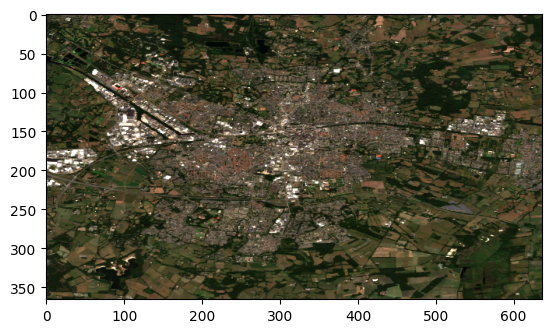

In [18]:
#example workflow
#load a GEE satellite img as a tif with all of its bands
img = read_tif_as_rgb("C:/Users/windows-game-pc/Downloads/Enschede.tif")
#get a normalized rgb img by selecting 3 bands
img_normalized = rgb_color_normalization(img,4) 
#show the img
plt.imshow(img_normalized)
#save the rgb img if needed
if True:
    save_normalized_image(img_rgb = img_normalized, filename='normalized.png')